In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

In [2]:
def find_sod_robust_threshold(data, test_name, bearing_name, baseline_frac=0.2, 
                             smooth_window=50, 
                             sigma_factor=3.0, 
                             persistence_count=20):
    """
    Finds the Start of Degradation (SoD) using a robust, smoothed
    thresholding method with a persistence check.
    
    Args:
        data (np.array): 1D array of the signal metric (e.g., RMS or Kurtosis).
        ... [rest of docstring] ...
    """
    if data.ndim != 1:
        raise ValueError("Input data must be a 1D numpy array.")
        
    # 1. Establish healthy baseline
    baseline_samples = int(len(data) * baseline_frac)
    if baseline_samples < 20:
        baseline_samples = min(len(data), 20)
        
    baseline_data = data[:baseline_samples]
    
    if np.isnan(baseline_data).all():
        print(f"Error: Baseline data for {test_name} - {bearing_name} is all NaN.")
        return -1, np.zeros(len(data)), 1
        
    mu_0 = np.nanmean(baseline_data)
    sigma = np.nanstd(baseline_data)
    
    if sigma < 1e-6:
        # A low variance in baseline Kurtosis is common and expected
        if np.isclose(mu_0, 0): # Check if baseline is near Gaussian (kurtosis=0)
             print(f"Info: Healthy baseline with low variance (Std={sigma:.2e}) for {test_name} - {bearing_name}.")
        sigma = 1e-6 # Avoid division by zero

    # 2. Define the static threshold
    threshold = mu_0 + sigma_factor * sigma

    # 3. Smooth the *entire* signal
    smoothed_signal = pd.Series(data).rolling(window=smooth_window, min_periods=1).mean().values

    # 4. Find SoD with persistence check
    sod_index = -1
    above_threshold_counter = 0
    
    for i in range(baseline_samples, len(smoothed_signal)):
        if np.isnan(smoothed_signal[i]):
            above_threshold_counter = 0
            continue
            
        if smoothed_signal[i] > threshold:
            above_threshold_counter += 1
        else:
            above_threshold_counter = 0
            
        if above_threshold_counter >= persistence_count:
            sod_index = i - persistence_count + 1
            break 

    print(f"\n--- Analyzing {test_name} - {bearing_name} ---")
    print(f"Baseline (first {baseline_samples} files): Mean={mu_0:.4f}, Std={sigma:.4f}")
    print(f"Params: SmoothWindow={smooth_window}, SigmaFactor={sigma_factor}, Persistence={persistence_count}")
    print(f"Calculated Threshold: {threshold:.4f}")
    
    if sod_index != -1:
        print(f"SoD Detected at file index: {sod_index} ({(sod_index/len(data)*100):.2f}% of life)")
    else:
        print("SoD NOT detected. Bearing likely remained healthy.")
        
    return sod_index, smoothed_signal, threshold

In [3]:
def get_feature_series_from_files(data_path, col_index, feature_type='kurtosis'):
    """
    Processes a directory of files, calculating one feature value (e.g., RMS
    or Kurtosis) per file for the specified column.
    
    Args:
        data_path (str): Path to the directory containing the data files.
        col_index (int): The column index (bearing channel) to read.
        feature_type (str): 'rms' or 'kurtosis'.

    Returns:
        np.array: 1D array of feature values, one for each file.
    """
    all_files = sorted(glob.glob(os.path.join(data_path, "*")))
    if not all_files:
        print(f"Warning: No files found in {data_path}")
        return np.array([])
    
    feature_list = []
    for file in all_files:
        try:
            df = pd.read_csv(file, sep='\t', header=None, usecols=[col_index])
            signal_chunk = df[col_index].values
            
            # Calculate the requested feature
            if feature_type == 'rms':
                val = np.sqrt(np.mean(signal_chunk**2))
            elif feature_type == 'kurtosis':
                # fisher=True calculates "excess kurtosis", where 0 is a
                # perfect Gaussian signal. This is standard practice.
                val = kurtosis(signal_chunk, fisher=True)
            else:
                raise ValueError("Unknown feature_type. Use 'rms' or 'kurtosis'.")
                
            feature_list.append(val)
            
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            feature_list.append(np.nan)
    
    return np.array(feature_list)

In [4]:
def analyze_and_plot_fast(test_name, data_path, bearings_map, feature_type='kurtosis'):
    """
    Main function to process and plot SoD for a given test set
    using the specified feature (RMS or Kurtosis).
    
    Args:
        test_name (str): Name of the test (e.g., '1st_test').
        data_path (str): Path to the test's data directory.
        bearings_map (dict): Dictionary mapping bearing names to column indices.
        feature_type (str): 'rms' or 'kurtosis'.
    """
    print(f"\n=============================================")
    print(f"Processing Test Set: {test_name} using Feature: {feature_type.upper()}")
    print(f"Data Path: {data_path}")
    print(f"=============================================")

    for bearing_name, col_index in bearings_map.items():
        # 1. Get the feature time-series
        feature_series = get_feature_series_from_files(data_path, col_index, feature_type)
        
        if feature_series.size == 0:
            print(f"No data found for {bearing_name}. Skipping.")
            continue
            
        # 2. Find SoD using the ROBUST Threshold method
        baseline_fraction = 0.2 if test_name == '1st_test' else 0.1
        
        # --- Parameters for the robust method ---
        # These statistical parameters should still work well for Kurtosis!
        # A 2-sigma change is a 2-sigma change, regardless of the feature.
        smoothing_w = 50       
        sigma_f = 2.0          
        persistence_p = 50     
        # ----------------------------------------

        sod_idx, smoothed_feature, threshold = find_sod_robust_threshold(
            feature_series, 
            test_name, 
            bearing_name,
            baseline_frac=baseline_fraction,
            smooth_window=smoothing_w,
            sigma_factor=sigma_f,
            persistence_count=persistence_p
        )

        # 3. Plot the results
        plt.figure(figsize=(15, 6))
        
        # Plot Raw Feature
        plt.plot(feature_series, label=f'Raw File-by-File {feature_type.upper()}', color='gray', alpha=0.4)
        
        # Plot Threshold
        plt.axhline(y=threshold, color='red', linestyle='--', 
                    label=f'SoD Threshold ({threshold:.2f})')
        
        # Create masked arrays
        below_thresh = np.ma.masked_where(smoothed_feature >= threshold, smoothed_feature)
        above_thresh = np.ma.masked_where(smoothed_feature < threshold, smoothed_feature)

        # Plot the smoothed signal in two colors
        plt.plot(below_thresh, color='blue', label='Smoothed (Below Threshold)')
        plt.plot(above_thresh, color='orange', label='Smoothed (Above Threshold)')

        # Plot SoD Line
        if sod_idx != -1:
            plt.axvline(x=sod_idx, color='black', linestyle='--', 
                        label=f'SoD Detected (File #{sod_idx})')
        
        plt.title(f'{test_name} - {bearing_name} - {feature_type.upper()} SoD Analysis', 
                  fontsize=16)
        plt.xlabel('File Index (Time)')
        plt.ylabel(f'{feature_type.upper()} (Unitless)')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [5]:
# This is the base path in the Kaggle environment.
# Adjust this path if you are running this locally.
BASE_PATH = '/kaggle/input/nasa-bearings-dataset-from-phm-society-website/4. Bearings/IMS'

# Dataset 1: 8 channels
path_1st = os.path.join(BASE_PATH, '1st_test', '1st_test')
bearings_1st_all = {
    'B1-Ch1 (Healthy)': 0,
    'B1-Ch2 (Healthy)': 1,
    'B2-Ch1 (Healthy)': 2,
    'B2-Ch2 (Healthy)': 3,
    'B3-Ch1 (Fail-Inner)': 4,
    'B3-Ch2 (Fail-Inner)': 5,
    'B4-Ch1 (Fail-Roller)': 6,
    'B4-Ch2 (Fail-Roller)': 7
}

# Dataset 2: 4 channels
path_2nd = os.path.join(BASE_PATH, '2nd_test', '2nd_test')
bearings_2nd_all = {
    'B1-Ch1 (Fail-Outer)': 0,
    'B2-Ch1 (Healthy)': 1,
    'B3-Ch1 (Healthy)': 2,
    'B4-Ch1 (Healthy)': 3
}

# Dataset 3: 4 channels
path_3rd = os.path.join(BASE_PATH, '3rd_test', '4th_test', 'txt')
bearings_3rd_all = {
    'B1-Ch1 (Healthy)': 0,
    'B2-Ch1 (Healthy)': 1,
    'B3-Ch1 (Fail-Outer)': 2,
    'B4-Ch1 (Healthy)': 3
}

Starting analysis for 1st Test Set (All Bearings) using KURTOSIS

Processing Test Set: 1st_test using Feature: KURTOSIS
Data Path: /kaggle/input/nasa-bearings-dataset-from-phm-society-website/4. Bearings/IMS/1st_test/1st_test

--- Analyzing 1st_test - B1-Ch1 (Healthy) ---
Baseline (first 431 files): Mean=0.9795, Std=0.2231
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 1.4257
SoD NOT detected. Bearing likely remained healthy.


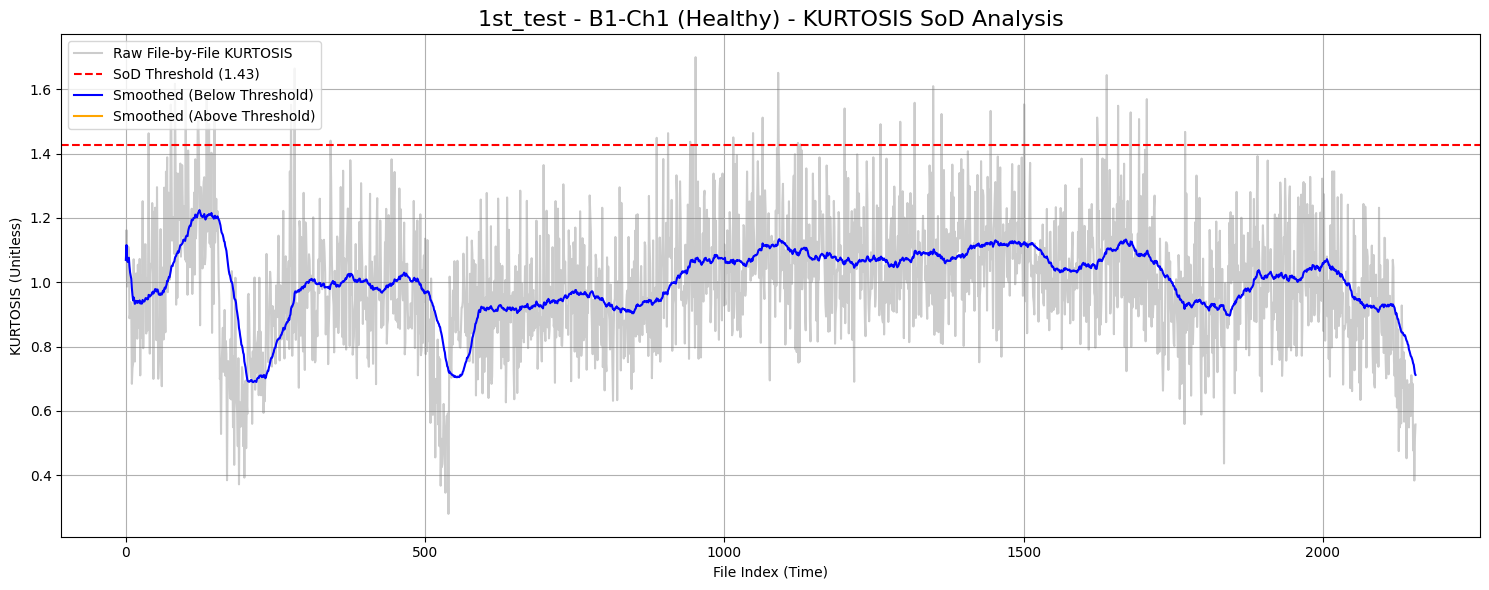


--- Analyzing 1st_test - B1-Ch2 (Healthy) ---
Baseline (first 431 files): Mean=1.2025, Std=0.3731
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 1.9488
SoD NOT detected. Bearing likely remained healthy.


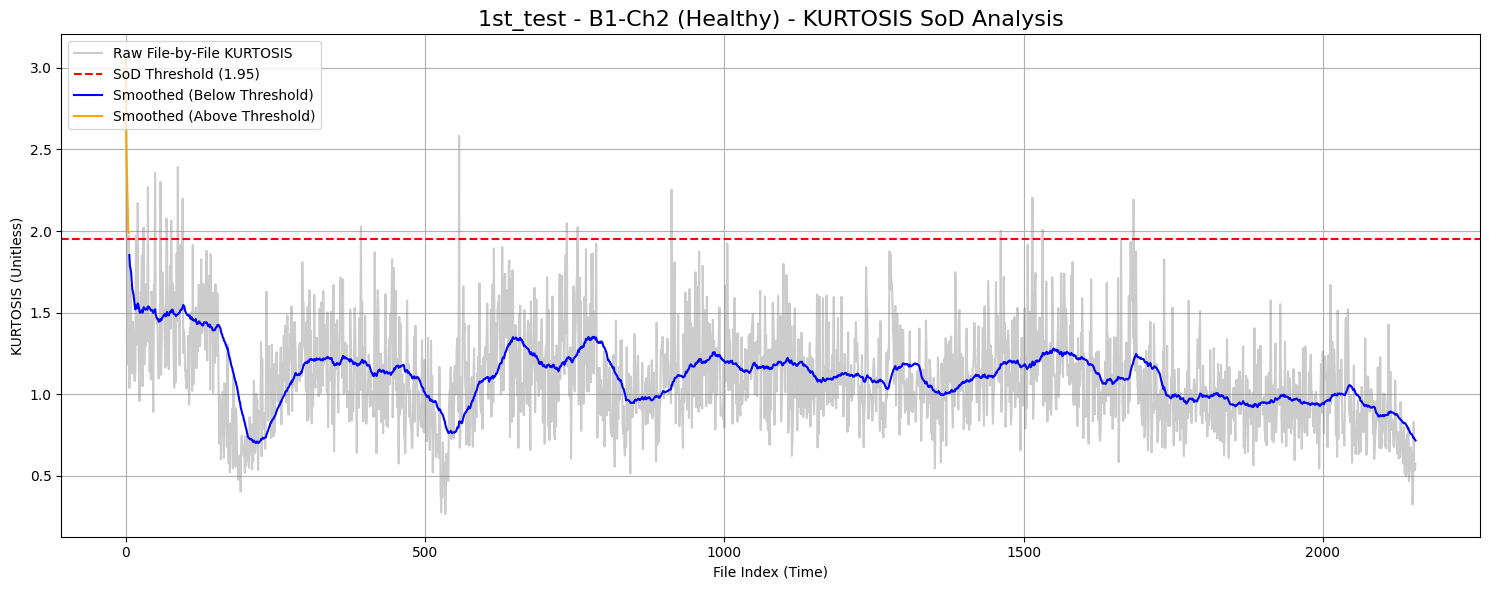


--- Analyzing 1st_test - B2-Ch1 (Healthy) ---
Baseline (first 431 files): Mean=0.2226, Std=0.1056
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.4339
SoD NOT detected. Bearing likely remained healthy.


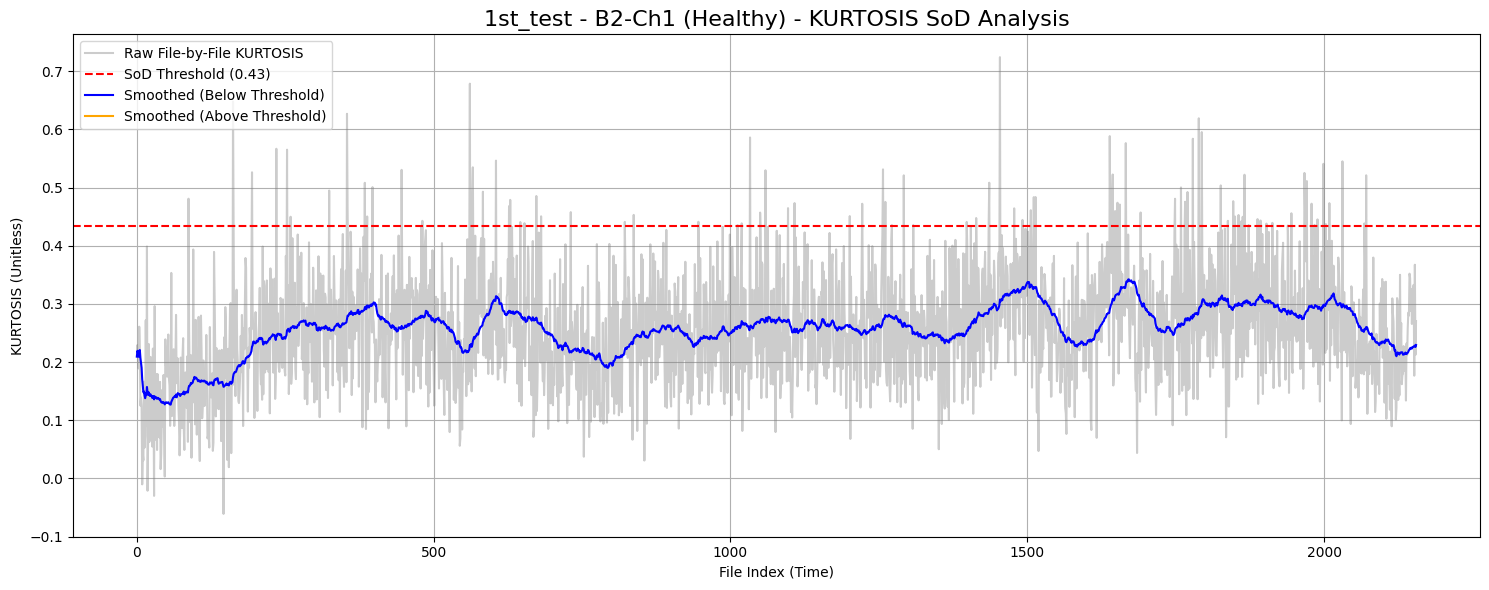


--- Analyzing 1st_test - B2-Ch2 (Healthy) ---
Baseline (first 431 files): Mean=0.3420, Std=0.1060
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.5539
SoD NOT detected. Bearing likely remained healthy.


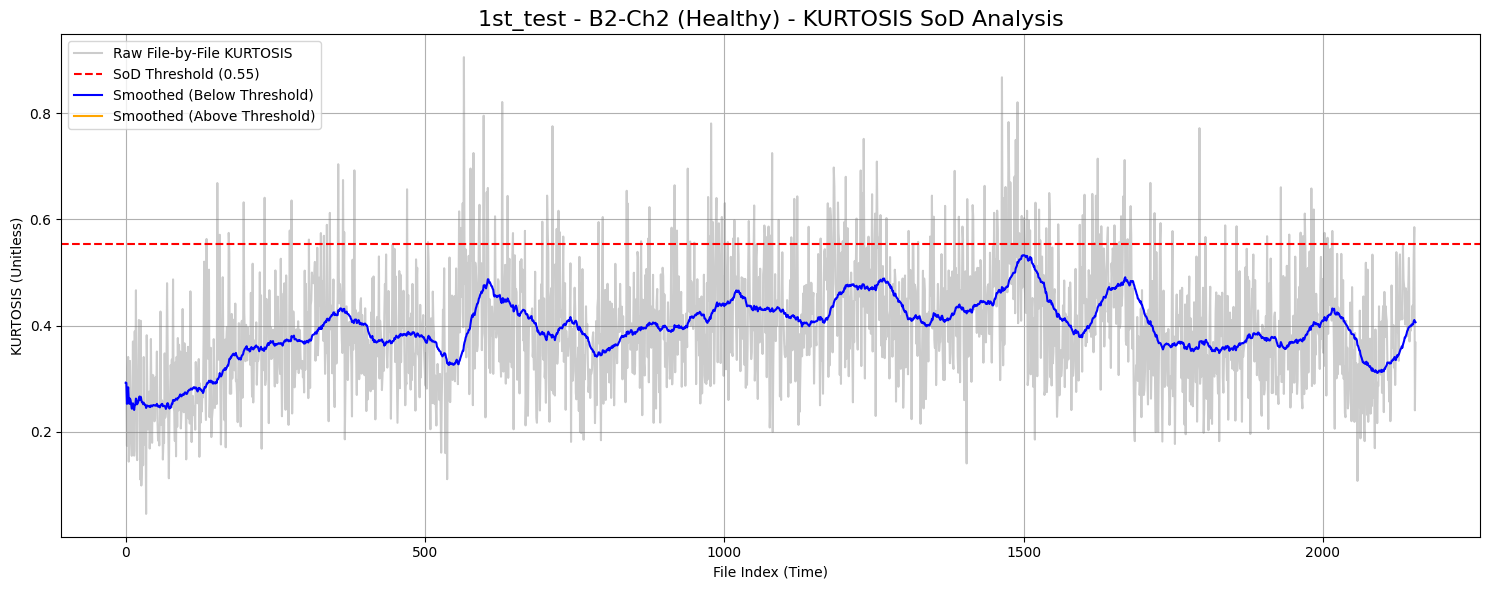


--- Analyzing 1st_test - B3-Ch1 (Fail-Inner) ---
Baseline (first 431 files): Mean=0.4087, Std=0.1093
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.6272
SoD Detected at file index: 904 (41.93% of life)


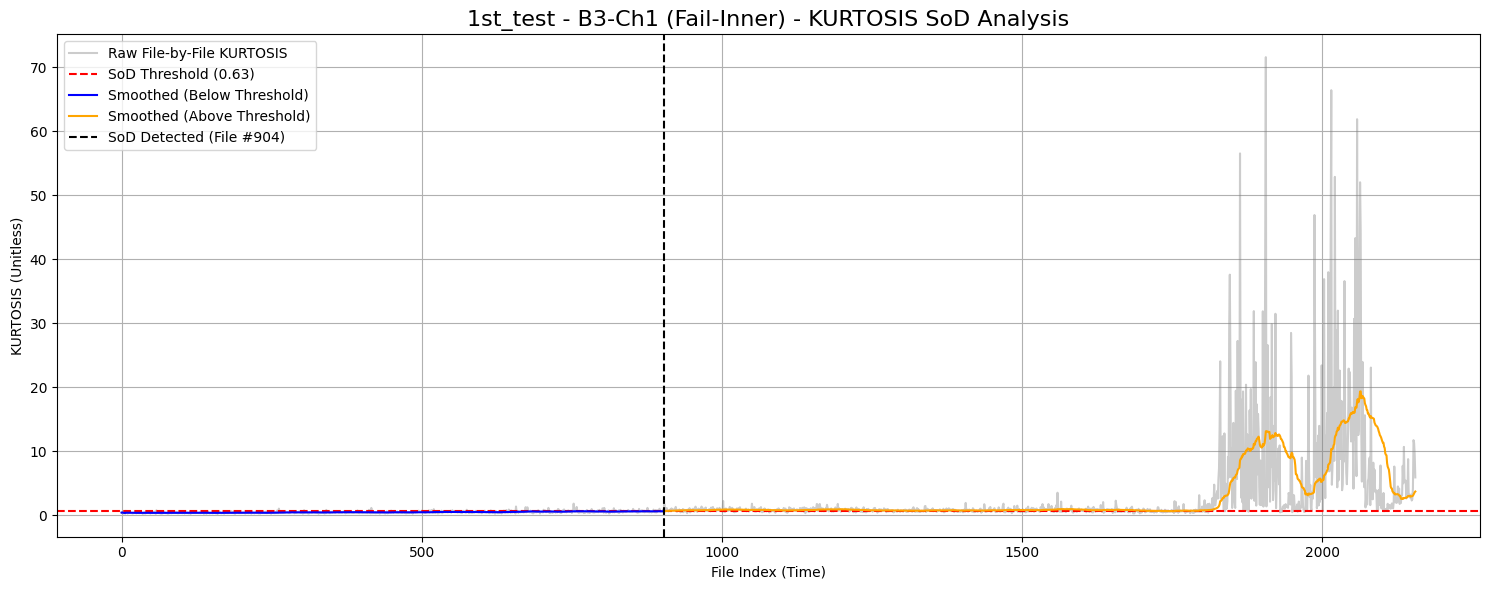


--- Analyzing 1st_test - B3-Ch2 (Fail-Inner) ---
Baseline (first 431 files): Mean=0.5447, Std=0.1329
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.8105
SoD Detected at file index: 1837 (85.20% of life)


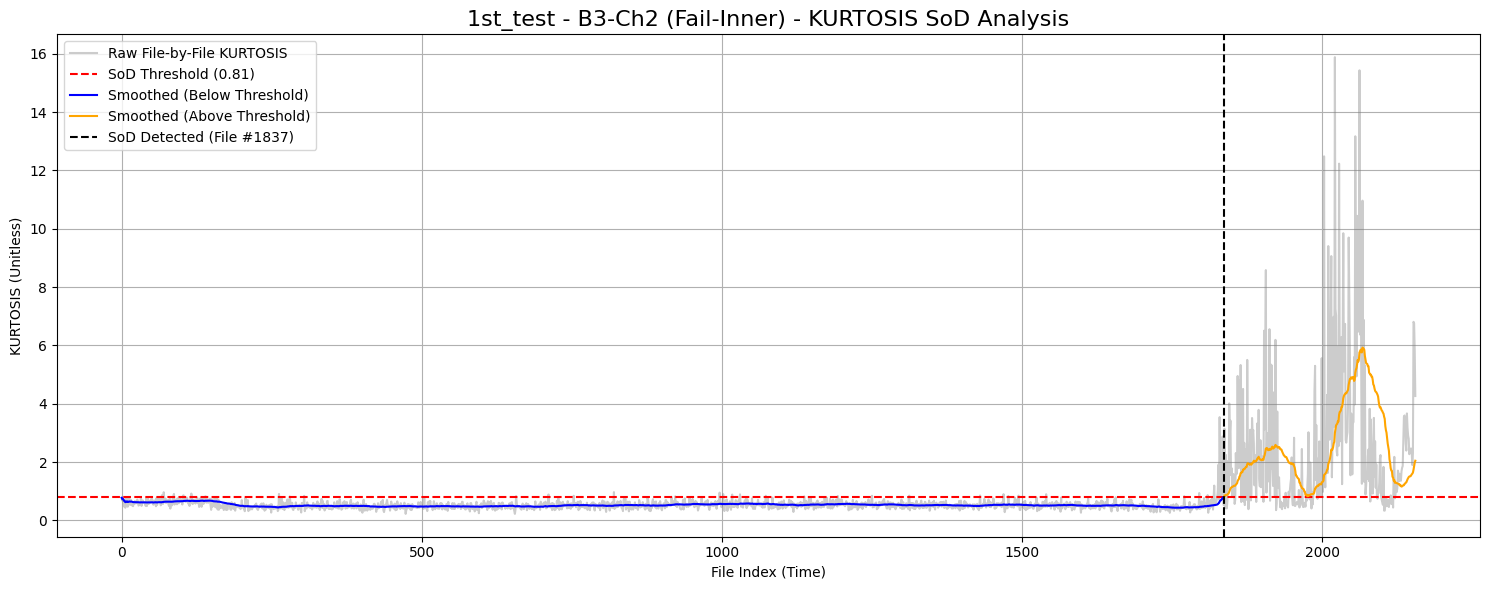


--- Analyzing 1st_test - B4-Ch1 (Fail-Roller) ---
Baseline (first 431 files): Mean=1.2803, Std=0.4701
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 2.2205
SoD Detected at file index: 1467 (68.04% of life)


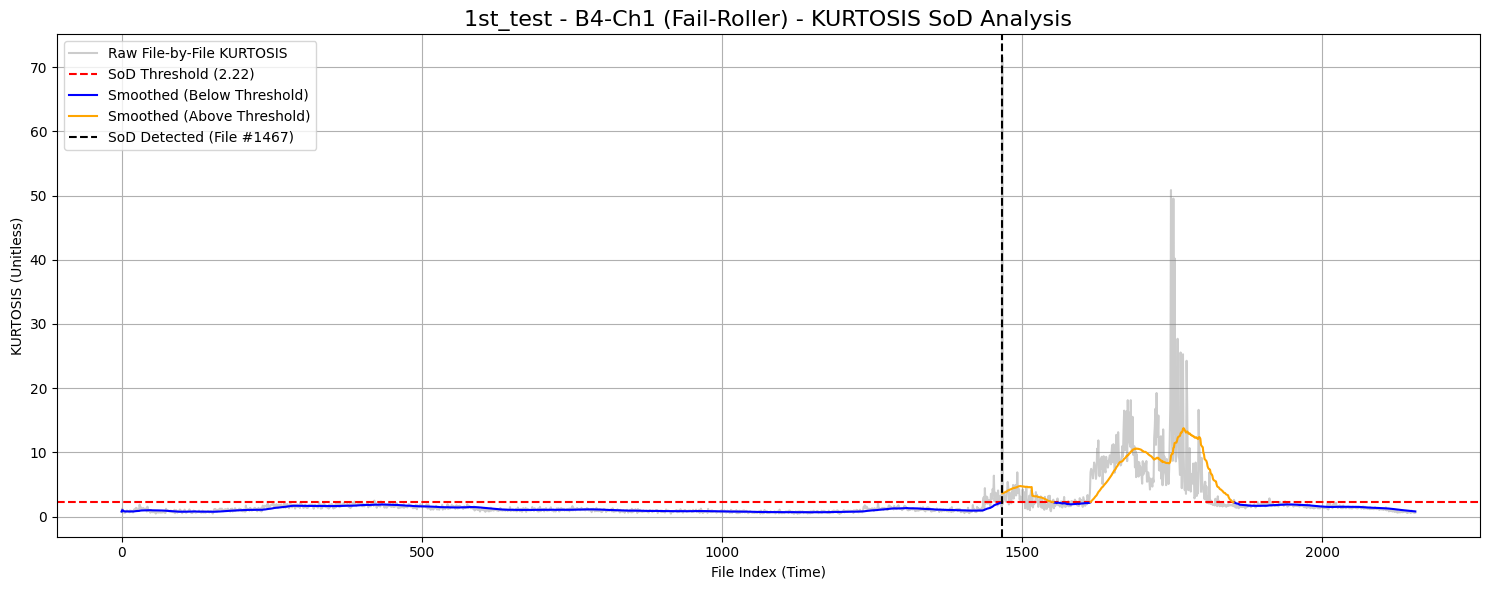


--- Analyzing 1st_test - B4-Ch2 (Fail-Roller) ---
Baseline (first 431 files): Mean=1.7319, Std=0.4401
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 2.6120
SoD Detected at file index: 1625 (75.37% of life)


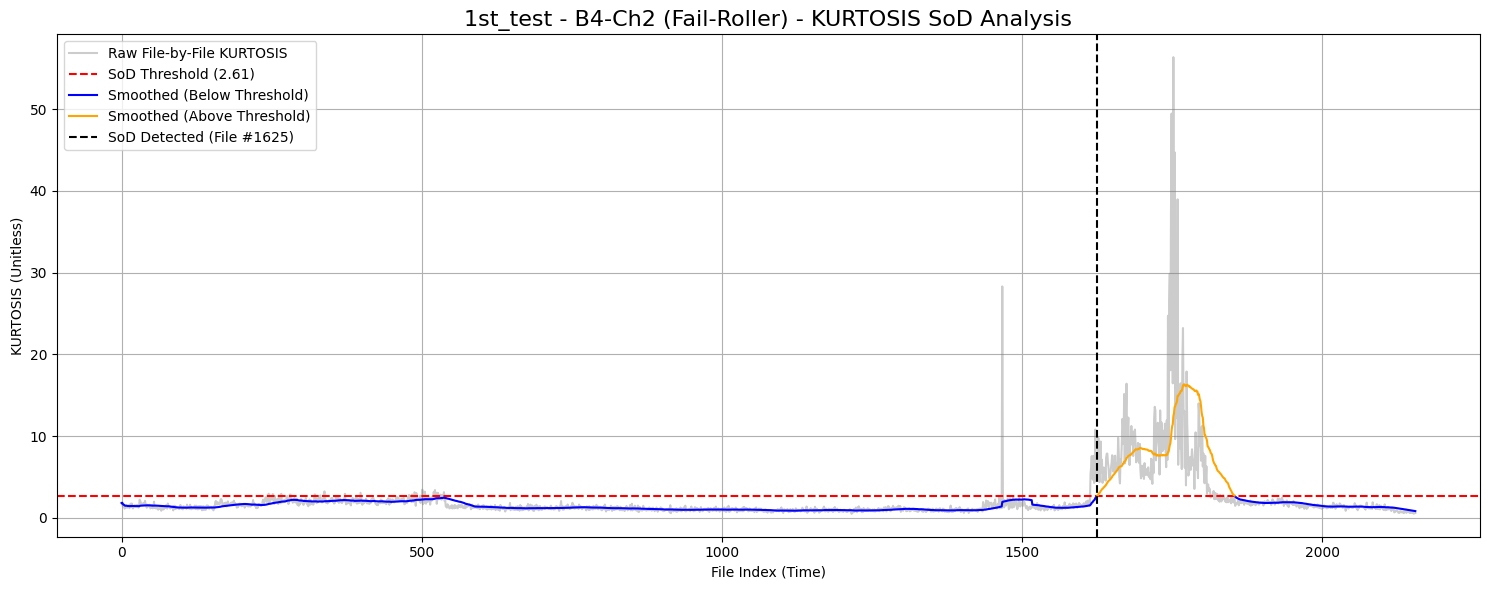

In [6]:
print("Starting analysis for 1st Test Set (All Bearings) using KURTOSIS")
analyze_and_plot_fast('1st_test', path_1st, bearings_1st_all, feature_type='kurtosis')


Starting analysis for 2nd Test Set (All Bearings) using KURTOSIS

Processing Test Set: 2nd_test using Feature: KURTOSIS
Data Path: /kaggle/input/nasa-bearings-dataset-from-phm-society-website/4. Bearings/IMS/2nd_test/2nd_test

--- Analyzing 2nd_test - B1-Ch1 (Fail-Outer) ---
Baseline (first 98 files): Mean=0.4644, Std=0.1173
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.6990
SoD Detected at file index: 666 (67.68% of life)


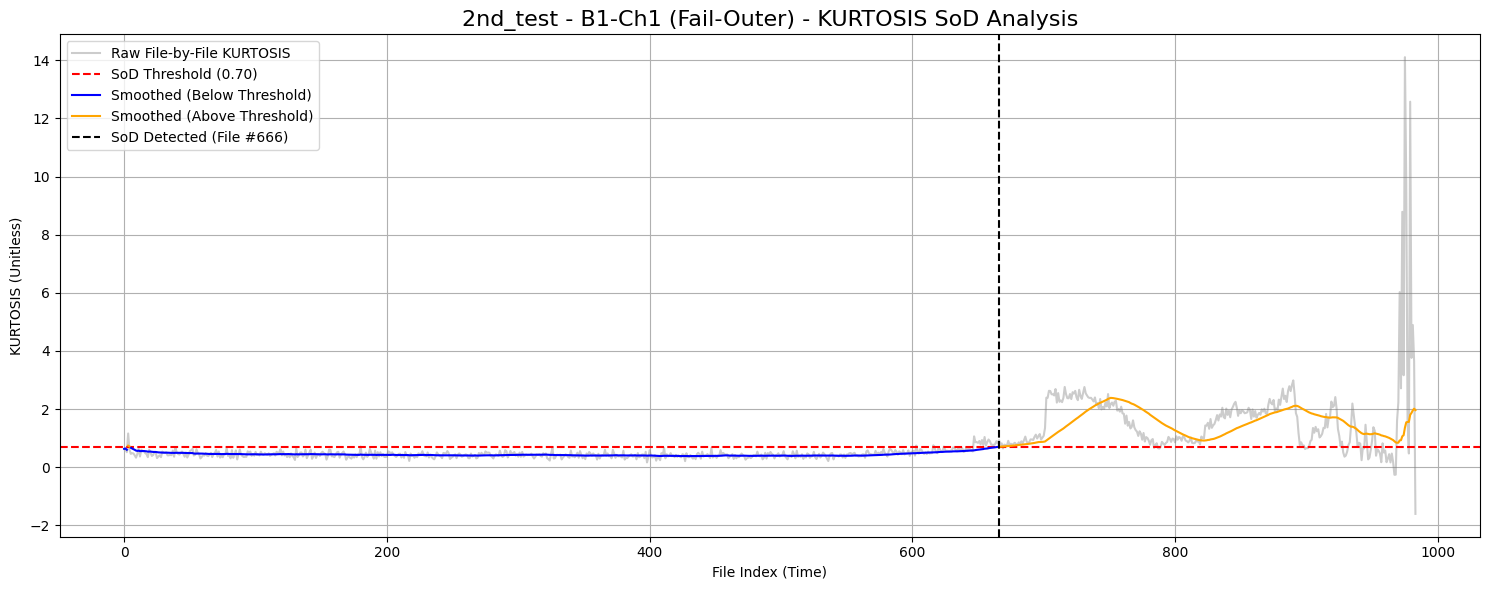


--- Analyzing 2nd_test - B2-Ch1 (Healthy) ---
Baseline (first 98 files): Mean=0.2117, Std=0.0785
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.3687
SoD NOT detected. Bearing likely remained healthy.


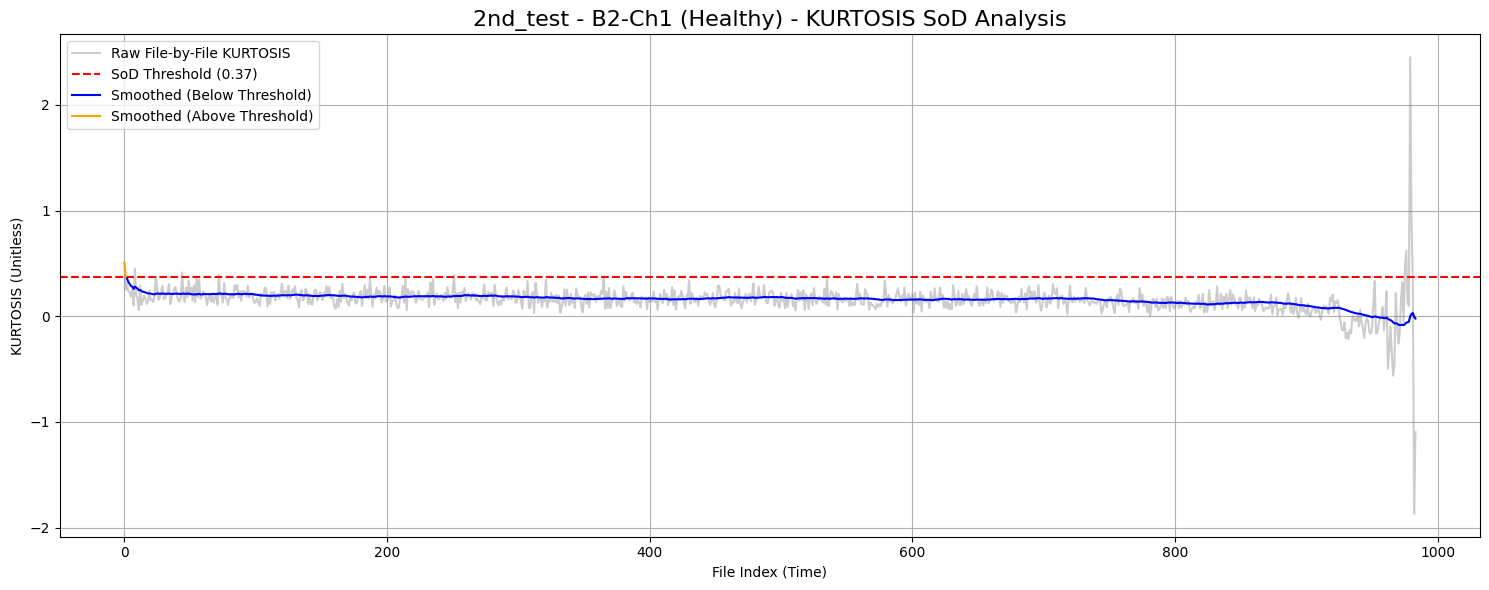


--- Analyzing 2nd_test - B3-Ch1 (Healthy) ---
Baseline (first 98 files): Mean=1.5802, Std=0.5493
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 2.6788
SoD NOT detected. Bearing likely remained healthy.


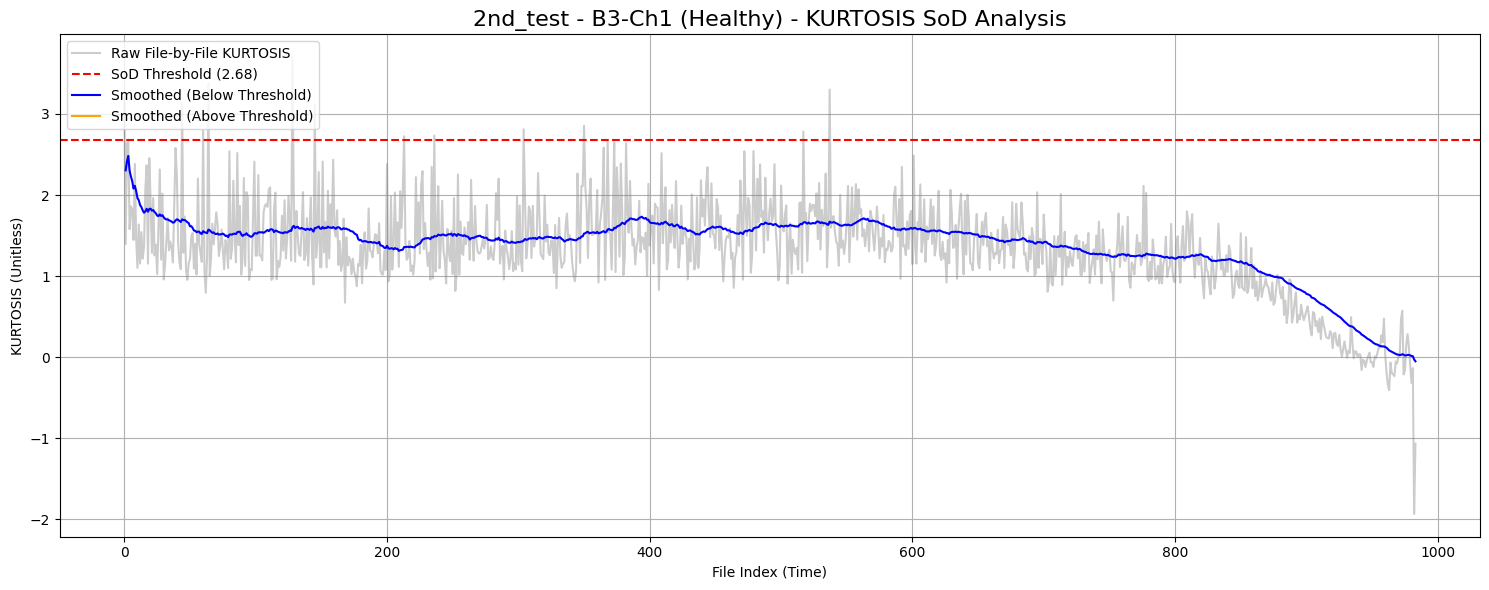


--- Analyzing 2nd_test - B4-Ch1 (Healthy) ---
Baseline (first 98 files): Mean=0.1484, Std=0.0903
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.3290
SoD NOT detected. Bearing likely remained healthy.


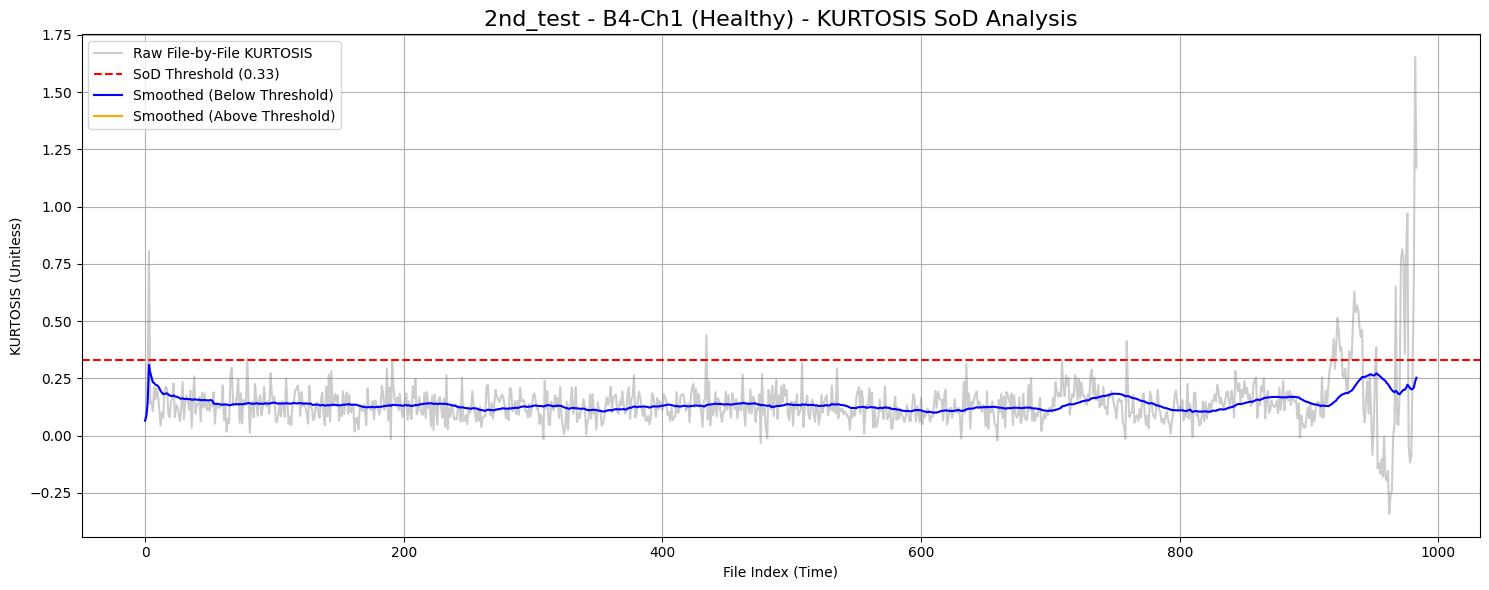

In [7]:
print("\nStarting analysis for 2nd Test Set (All Bearings) using KURTOSIS")
analyze_and_plot_fast('2nd_test', path_2nd, bearings_2nd_all, feature_type='kurtosis')


Starting analysis for 3rd Test Set (All Bearings) using KURTOSIS

Processing Test Set: 3rd_test using Feature: KURTOSIS
Data Path: /kaggle/input/nasa-bearings-dataset-from-phm-society-website/4. Bearings/IMS/3rd_test/4th_test/txt

--- Analyzing 3rd_test - B1-Ch1 (Healthy) ---
Baseline (first 632 files): Mean=0.5370, Std=0.2422
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 1.0213
SoD NOT detected. Bearing likely remained healthy.


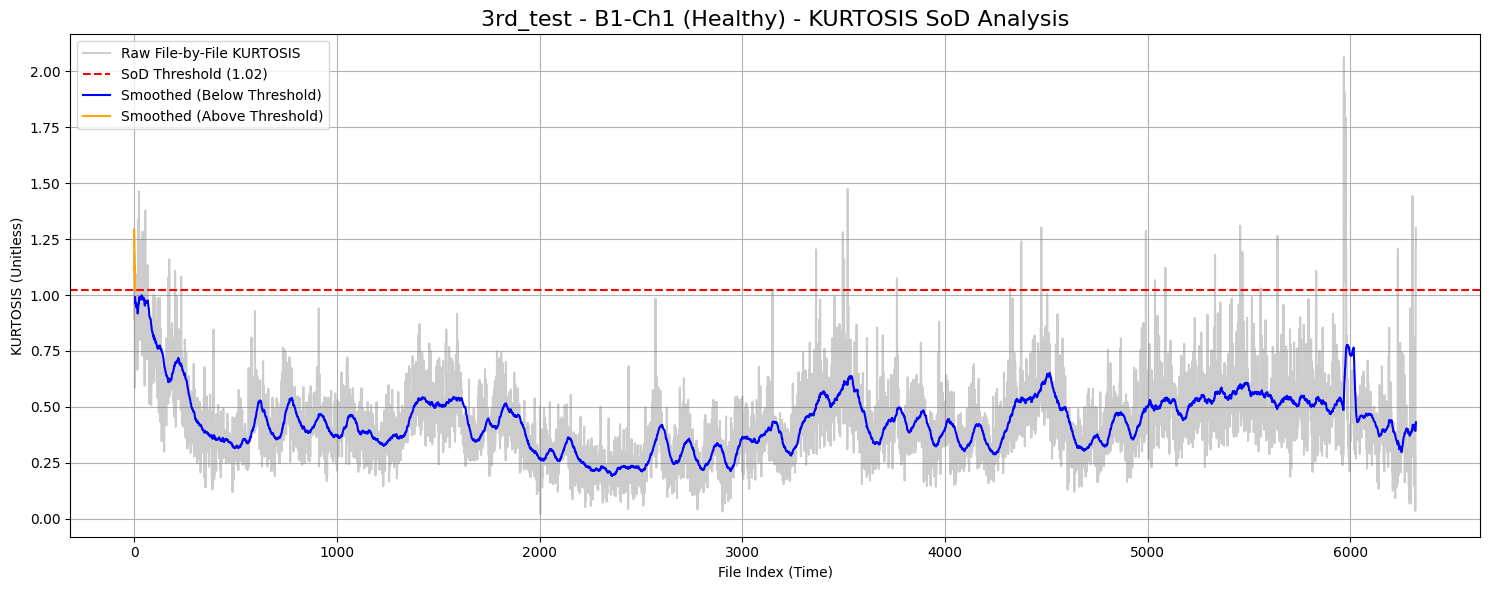


--- Analyzing 3rd_test - B2-Ch1 (Healthy) ---
Baseline (first 632 files): Mean=0.3138, Std=0.1672
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.6481
SoD NOT detected. Bearing likely remained healthy.


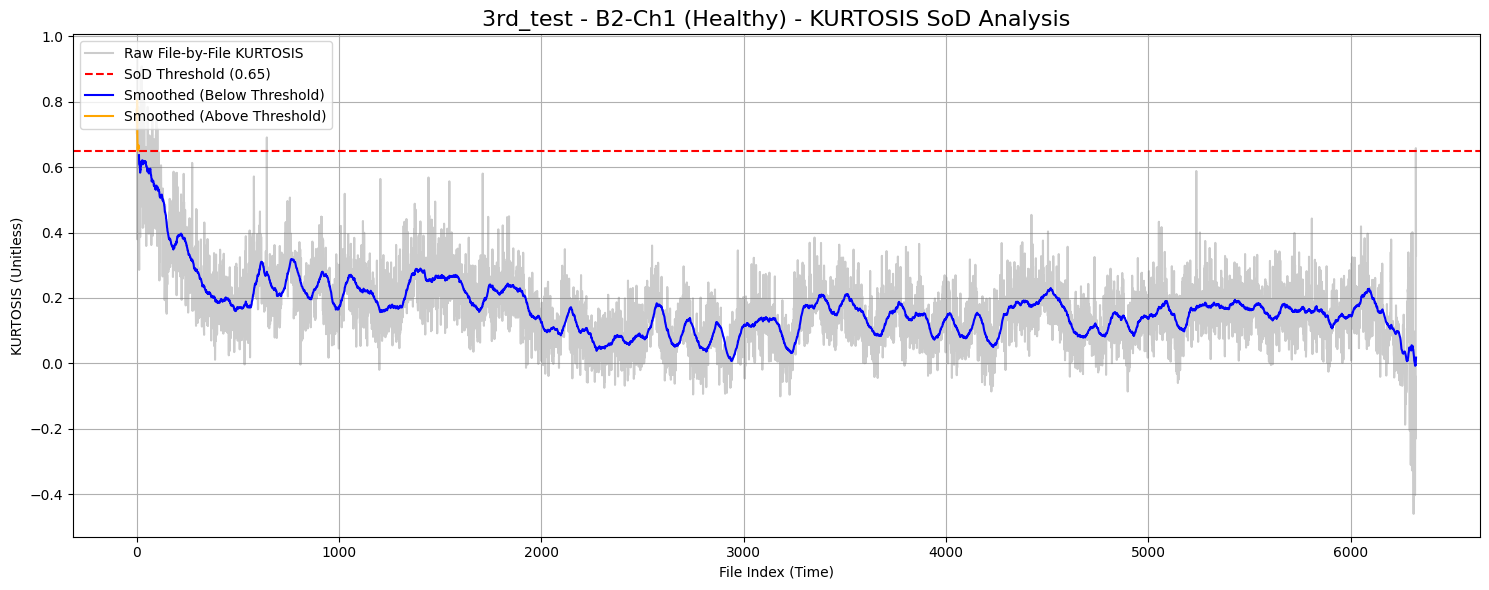


--- Analyzing 3rd_test - B3-Ch1 (Fail-Outer) ---
Baseline (first 632 files): Mean=0.1799, Std=0.1498
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.4796
SoD Detected at file index: 6179 (97.71% of life)


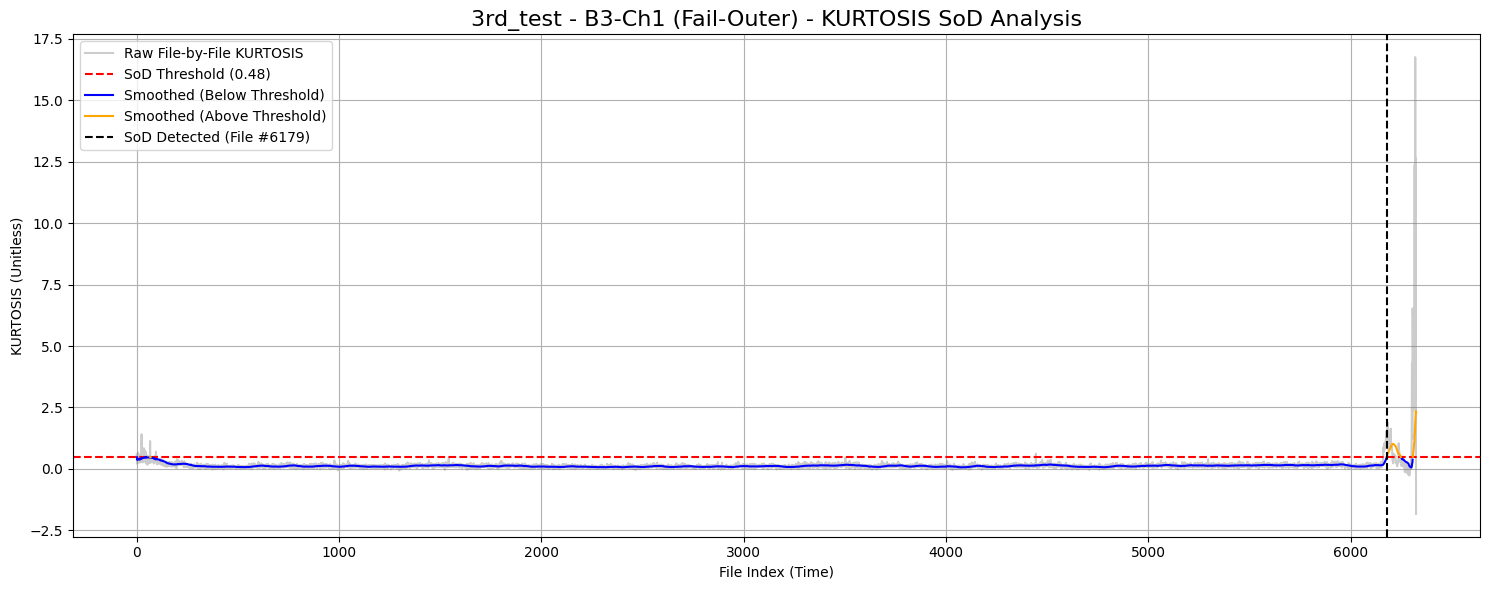


--- Analyzing 3rd_test - B4-Ch1 (Healthy) ---
Baseline (first 632 files): Mean=0.2435, Std=0.1060
Params: SmoothWindow=50, SigmaFactor=2.0, Persistence=50
Calculated Threshold: 0.4556
SoD NOT detected. Bearing likely remained healthy.


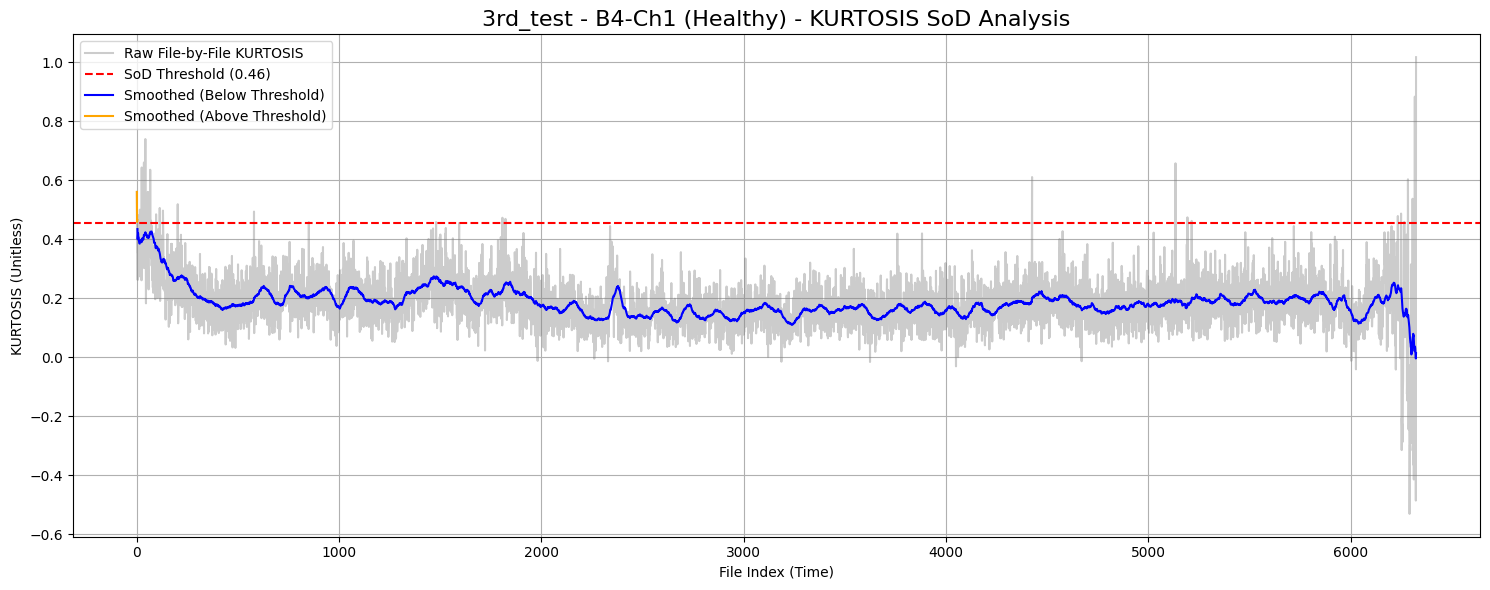

In [8]:
print("\nStarting analysis for 3rd Test Set (All Bearings) using KURTOSIS")
analyze_and_plot_fast('3rd_test', path_3rd, bearings_3rd_all, feature_type='kurtosis')